# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [41]:
# Install Required packages
!pip install -q keras
!pip install -U 'opencv-python==3.2.0.6'
!pip install -U tqdm

Requirement already up-to-date: opencv-python==3.2.0.6 in /usr/local/lib/python3.6/dist-packages
Requirement already up-to-date: numpy>=1.11.3 in /usr/local/lib/python3.6/dist-packages (from opencv-python==3.2.0.6)
Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages


In [79]:
from keras.utils import get_file

#download dataset for google colab
get_file('dogImages.zip','https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip', extract=True)
get_file('lfw.zip','https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip', extract=True)
get_file('DogVGG16Data.npz','https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz')
get_file('haarcascade_frontalface_alt.xml', 'https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_alt.xml')
get_file('DogInceptionV3Data.npz','https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz')

1710292992/1710285390 [==============================] - 26s 0us/step


'/content/.keras/datasets/DogInceptionV3Data.npz'

In [111]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

DS_MAIN_PATH = '/content/.keras/datasets/'

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(DS_MAIN_PATH + path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20 + len(DS_MAIN_PATH):-1] for item in sorted(glob(DS_MAIN_PATH + "dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [87]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob(DS_MAIN_PATH + "lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


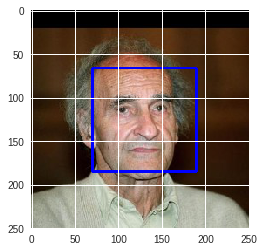

In [88]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(DS_MAIN_PATH + 'haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0), 2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

1. 99%
2. 11%

In [0]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

In [5]:
## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
det_human = 0
det_dogs_human = 0

for i in range(100):
  det_human += face_detector(human_files_short[i])
  det_dogs_human = det_dogs_human + face_detector(dog_files_short[i])

print('Correctly Classified Humans: {det_human}%'.format(det_human=det_human))
print('Misclassified Dogs as humans: {det_dogs_human}%'.format(det_dogs_human=det_dogs_human))

Correctly Classified Humans: 99%
Misclassified Dogs as humans: 11%


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

It's not reasonable or feasible to pose this restriction on the user as we should be able to handle all use cases and errors in our application,
we can try to see other state of the art Object detection techniques such as `YoloV2`

With Yolo we got the same 99% accuracy on correct humans detection and only 2% missclassified dogs as humans a 9% improvement over OpenCV implementation, we also got 82% correct dog classification.

In [3]:
## Install YAD2K
!rm -f YAD2K
!git clone https://github.com/allanzelener/YAD2K.git
!mv -f YAD2K/** .

fatal: destination path 'YAD2K' already exists and is not an empty directory.
environment.yml  images      README.md	      train_overfit.py	      yad2k.py
etc		 LICENSE     retrain_yolo.py  voc_conversion_scripts
font		 model_data  test_yolo.py     yad2k


In [0]:
## Download Weights && Generate H5
!wget http://pjreddie.com/media/files/yolo.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolo.cfg
!./yad2k.py yolo.cfg yolo.weights model_data/yolo.h5

In [0]:
## Create Anchors
!touch model_data/yolo_anchors.txt
!echo "0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828" > model_data/yolo_anchors.txt

In [0]:
## Utils for Yolo
import matplotlib.image as mpimg

def preprocess_img_for_yolo(img_path, is_fixed_size = True):
  ## TODO handle if not fixed size
  image = Image.open(os.path.join(img_path))
  resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
  image_data = np.array(resized_image, dtype='float32')
  image_data /= 255.
  image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
  return image, image_data

def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
  font = ImageFont.truetype(font='font/FiraMono-Medium.otf',size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
  thickness = (image.size[0] + image.size[1]) // 300

  for i, c in reversed(list(enumerate(out_classes))):
      predicted_class = class_names[c]
      box = out_boxes[i]
      score = out_scores[i]

      label = '{} {:.2f}'.format(predicted_class, score)

      draw = ImageDraw.Draw(image)
      label_size = draw.textsize(label, font)

      top, left, bottom, right = box
      top = max(0, np.floor(top + 0.5).astype('int32'))
      left = max(0, np.floor(left + 0.5).astype('int32'))
      bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
      right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
#       print(label, (left, top), (right, bottom))

      if top - label_size[1] >= 0:
          text_origin = np.array([left, top - label_size[1]])
      else:
          text_origin = np.array([left, top + 1])

      # My kingdom for a good redistributable image drawing library.
      for i in range(thickness):
          draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
      draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
      draw.text(text_origin, label, fill=(0, 0, 0), font=font)
      del draw

def err_analysis(image, out_scores, out_boxes, out_classes, class_names, colors):
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    fname = str(np.random.randint(10000))
    image.save(os.path.join('./outputs', fname + '.jpg'), quality=100)
    plt.axis('off')
    plt.grid('off')

In [91]:
import os
import random

import numpy as np
from keras import backend as K
from keras.models import load_model
from PIL import Image, ImageDraw, ImageFont

from yad2k.models.keras_yolo import yolo_eval, yolo_head

sess = K.get_session()

classes_path = './model_data/coco_classes.txt'
anchors_path = './model_data/yolo_anchors.txt'
model_path   = './model_data/yolo.h5'

with open(classes_path) as f:
    class_names = f.readlines()
class_names = [c.strip() for c in class_names]

with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)
    
yolo_model = load_model(model_path)

/usr/local/lib/python3.6/dist-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
num_classes = len(class_names)
num_anchors = len(anchors)

## Dimensions ordering is channels last
model_output_channels = yolo_model.layers[-1].output_shape[-1]
if model_output_channels != num_anchors * (num_classes + 5):
  print('Output channels mismatch')

In [0]:
model_image_size = yolo_model.layers[0].input_shape[1:3]
is_fixed_size = model_image_size != (None, None)

In [0]:
import colorsys

# Generate colors for drawing bounding boxes.
hsv_tuples = [(x / len(class_names), 1., 1.)
              for x in range(len(class_names))]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(
    map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
        colors))
random.seed(10101)  # Fixed seed for consistent colors across runs.
random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
random.seed(None)  # Reset seed to default.

In [0]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
input_image_shape = K.placeholder(shape=(2, ))

In [0]:
boxes, scores, classes = yolo_eval(yolo_outputs, input_image_shape, score_threshold=0.3, iou_threshold=0.5)

In [0]:
plt.ion()
def predict_class_yolo(sess, image_path):
  image, image_data = preprocess_img_for_yolo(image_path)
  out_boxes, out_scores, out_classes = sess.run(
      [boxes, scores, classes],
      feed_dict={
          yolo_model.input: image_data,
          input_image_shape: [image.size[1], image.size[0]],
          K.learning_phase(): 0
      })
  return image, image_data, out_boxes, out_scores, out_classes

def is_lbl(sess, lbl, image_path, plt_f = False, rev = 0):
  image, image_data, out_boxes, out_scores, out_classes = predict_class_yolo(sess, image_path)
  pred =  lbl in out_classes
  c = False
  if rev == -1:
    pred = pred and (16 not in out_classes)
    c = pred
  else:
    c = not pred
  
  if c and plt_f:
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    plt.grid('off')
    plt.axis('off')
    plt.imshow(image)
    plt.pause(0.00001)

  return pred
  

In [45]:
from tqdm import tqdm
## Test Yolo Accurracy
det_human = 0
det_dogs_human = 0
det_dogs_miss = 0

for i in tqdm(range(100)):
  det_human += is_lbl(sess, 0, human_files_short[i])
  det_dogs_human += is_lbl(sess, 16, dog_files_short[i])
  det_dogs_miss  += is_lbl(sess, 0, dog_files_short[i], False, -1)

print('\nHumans Correct Prediction: {det_human}%'.format(det_human=det_human))
print('Dogs Correct Prediction: {det_dogs_human}%'.format(det_dogs_human=det_dogs_human))
print('Dogs Miss Predicted as Humans: {det_dogs_miss}%'.format(det_dogs_miss=det_dogs_miss))


100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


Humans Correct Prediction: 99%
Dogs Correct Prediction: 82%
Dogs Miss Predicted as Humans: 2%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [46]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 7s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [0]:
from tqdm import tqdm
from keras.preprocessing import image
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, pb = 1):
    if pb:
      list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    else:
      list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [0]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [0]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
1. 0%
2. 100%

In [52]:
det_human = 0
det_dogs_human = 0

for i in range(100):
  det_human += dog_detector(human_files_short[i])
  det_dogs_human += dog_detector(dog_files_short[i])  

print('Misclassified Humans as Dogs: {det_human}%'.format(det_human=det_human))
print('Correctly classified Dogs: {det_dogs_human}%'.format(det_dogs_human=det_dogs_human))

Misclassified Humans as Dogs: 0%
Correctly classified Dogs: 100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [0]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# data doesn't fit in memory use keras fit_generator
def data_generator(x, y, bsz = 128):
  idx = 0
  sz = len(x)
  while True:
    yield paths_to_tensor(x[idx: idx + bsz], pb = 0).astype('float32')/255, y[idx: idx + bsz]
    idx += 1
    idx %= sz
    

In [6]:
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255

100%|██████████| 835/835 [00:06<00:00, 136.50it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

I first started by using a simple architecture such LeNet but didn't achieve the desired accuraccy accuracy, I experimented with several architectures until I reached to the following architecture adding and removing layers to tradeoff between accuracy and speed of learning.

In [53]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.models import Sequential
from keras import regularizers

## Conv1
model = Sequential()
model.add(Conv2D(16,  5, input_shape=(224, 224, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(16,  5, strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

## MaxPooling1
model.add(MaxPooling2D((2, 2)))

## Conv2
model.add(Conv2D(16,  3, strides=(1, 1), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32,  3, strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

## MaxPooling2
model.add(MaxPooling2D((5, 5)))

## Flatten
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(rate=0.5))

## Softmax
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 224, 224, 16)      1216      
_________________________________________________________________
batch_normalization_92 (Batc (None, 224, 224, 16)      64        
_________________________________________________________________
activation_92 (Activation)   (None, 224, 224, 16)      0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 224, 224, 16)      6416      
_________________________________________________________________
batch_normalization_93 (Batc (None, 224, 224, 16)      64        
_________________________________________________________________
activation_93 (Activation)   (None, 224, 224, 16)      0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 224, 224, 16)      0         
__________

### Compile the Model

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [0]:
from keras.callbacks import ModelCheckpoint  

epochs = 5
batch_size = 128
steps_per_epoch = len(train_files) / batch_size

model.load_weights('weights.best.from_scratch_cnn_2.hdf5')
checkpointer = ModelCheckpoint(filepath='weights.best.from_scratch_cnn_2.hdf5', 
                               verbose=1, save_best_only=True)

model.fit_generator(data_generator(x=train_files, y=train_targets, bsz=batch_size), validation_data=(valid_tensors, valid_targets),
          epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=[checkpointer])

### Load the Model with the Best Validation Loss

In [0]:
model.load_weights('weights.best.from_scratch_cnn_2.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [42]:
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 132.13it/s]


In [67]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 1.6746%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [0]:
bottleneck_features = np.load(DS_MAIN_PATH + 'DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [71]:
train_VGG16.shape[1:]

(7, 7, 512)

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [72]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [0]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the Model

In [74]:
checkpointer = ModelCheckpoint(filepath='weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6600/6680 [============================>.] - ETA: 0s - loss: 11.3514 - acc: 0.1636
Epoch 00001: val_loss improved from inf to 9.55995, saving model to weights.best.VGG16.hdf5
6680/6680 [==============================] - 4s 559us/step - loss: 11.3427 - acc: 0.1641 - val_loss: 9.5599 - val_acc: 0.2587
Epoch 2/20
6600/6680 [============================>.] - ETA: 0s - loss: 8.5033 - acc: 0.3694
Epoch 00002: val_loss improved from 9.55995 to 8.50821, saving model to weights.best.VGG16.hdf5
6680/6680 [==============================] - 2s 298us/step - loss: 8.5055 - acc: 0.3687 - val_loss: 8.5082 - val_acc: 0.3641
Epoch 3/20
6520/6680 [============================>.] - ETA: 0s - loss: 7.8070 - acc: 0.4558
Epoch 00003: val_loss improved from 8.50821 to 8.31378, saving model to weights.best.VGG16.hdf5
6680/6680 [==============================] - 2s 293us/step - loss: 7.7951 - acc: 0.4561 - val_loss: 8.3138 - val_acc: 0.3772
Epoch 4/20
65

### Load the Model with the Best Validation Loss

In [0]:
VGG16_model.load_weights('weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [76]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 44.9761%


### Predict Dog Breed with the Model

In [0]:
def extract_VGG16(tensor):
	from keras.applications.vgg16 import VGG16, preprocess_input
	return VGG16(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def extract_VGG19(tensor):
	from keras.applications.vgg19 import VGG19, preprocess_input
	return VGG19(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def extract_Resnet50(tensor):
	from keras.applications.resnet50 import ResNet50, preprocess_input
	return ResNet50(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def extract_Xception(tensor):
	from keras.applications.xception import Xception, preprocess_input
	return Xception(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def extract_InceptionV3(tensor):
	from keras.applications.inception_v3 import InceptionV3, preprocess_input
	return InceptionV3(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [0]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load(DS_MAIN_PATH + 'DogInceptionV3Data.npz')
train_Inception = bottleneck_features['train']
valid_Inception = bottleneck_features['valid']
test_Inception = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I used transfer learning using the `InceptionV3` Model, I then added an `GlobalAveragePooling2D` Layer to flatten the CNN and lastly a softmax layer for classification. The architecture is resonable since it's trained on `ImageNet` dataset which contains various images and features and serve as a good basis for our model, we didn't need to add more layers since the accuracy we achieved was beyond what's needed but adding more layers and regularization could help
since the model is overfitting on the training set.


In [81]:
InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=(train_Inception.shape[1:])))
InceptionV3_model.add(Dense(133, activation='softmax'))
InceptionV3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [0]:
InceptionV3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [83]:
checkpointer = ModelCheckpoint(filepath='weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

InceptionV3_model.fit(train_Inception, train_targets, 
          validation_data=(valid_Inception, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6600/6680 [============================>.] - ETA: 0s - loss: 1.2286 - acc: 0.6983
Epoch 00001: val_loss improved from inf to 0.68084, saving model to weights.best.InceptionV3.hdf5
6680/6680 [==============================] - 4s 653us/step - loss: 1.2235 - acc: 0.6996 - val_loss: 0.6808 - val_acc: 0.8096
Epoch 2/20
6600/6680 [============================>.] - ETA: 0s - loss: 0.4042 - acc: 0.8695
Epoch 00002: val_loss improved from 0.68084 to 0.63051, saving model to weights.best.InceptionV3.hdf5
6680/6680 [==============================] - 2s 350us/step - loss: 0.4048 - acc: 0.8693 - val_loss: 0.6305 - val_acc: 0.8359
Epoch 3/20
6560/6680 [============================>.] - ETA: 0s - loss: 0.2531 - acc: 0.9175
Epoch 00003: val_loss improved from 0.63051 to 0.60583, saving model to weights.best.InceptionV3.hdf5
6680/6680 [==============================] - 2s 356us/step - loss: 0.2521 - acc: 0.9177 - val_loss: 0.6058 - val_acc: 0.82

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [0]:
InceptionV3_model.load_weights('weights.best.InceptionV3.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [85]:
## Compare Accuracy with VGG16

VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy VGG16: %.4f%%' % test_accuracy)

##############################
# get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Inception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy InceptionV3: %.4f%%' % test_accuracy)

Test accuracy VGG16: 44.9761%
Test accuracy InceptionV3: 82.0574%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [0]:
def predict_breed_InceptionV3(img_path):
  bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
  predicted_vector = InceptionV3_model.predict(bottleneck_feature)
  return dog_names[np.argmax(predicted_vector)]  

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [0]:
HUMAN_NUM = 0
DOG_NUM = 16

def plt_img(img_path):
  plt.ion()
  from keras.preprocessing import image
  img = image.load_img(img_path)
  plt.axis('off')
  plt.grid('off')
  plt.imshow(img)
  plt.pause(0.00001)

def dog_breed_classifier(img_path):
  sess     = K.get_session()
  is_dog   = is_lbl(sess, DOG_NUM, img_path)
  is_human = is_lbl(sess, HUMAN_NUM, img_path)
  
  welcome_message = 'Hello, dog!'
  if not is_dog and not is_human:
    welcome_message = 'Sorry, Image doesn\'t contain human or dog.'
    print(welcome_message)
  else:
    if is_human:
      welcome_message = 'hello, human!'
    print(welcome_message)
    print('Your predicted breed is **drum rolls** ...')
    print(predict_breed_InceptionV3(img_path))
  
  plt_img(img_path)
  

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The algorithm got 5 out of 6 images correctly, this is within our expectations.

There are some room for improvement:
1. Increase the accuracy of the `Dog Bread Classifier`, the model is apparent to be overfitting on the training set.
2. Train the `YoloV2` algorithm on our images to increase the dog and human detection accuracy.
3. Train more models and build more complex model and experiment with ensemble learning.

In [148]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
!rm -rf !rm -rf /content/.keras/datasets/*.jpg
from keras.utils import get_file
# GoldenRet, HM, HM, Irish Water Spaniel, Belgian_sheepdog, Duck
imgs = ['https://www.what-dog.net/Images/faces2/scroll0015.jpg', 'https://i.imgur.com/Lxjr3e0.jpg',
        'https://cdn.cnn.com/cnnnext/dam/assets/171229130634-donald-trump-12-15-2017-large-169.jpg',
        'http://cdn3-www.dogtime.com/assets/uploads/gallery/irish-water-spaniel-dogs-and-puppies/thumbs/thumbs_irish-water-spaniel-5.jpg',
        'https://www.dogbreedinfo.com/images23/BelgianSheepdogGroenendaelerGroenendaelIndyt1.jpg', 
        'https://deltadailynews.com/wp-content/uploads/2016/06/ddn-duck.jpg']
for i in range(len(imgs)):
  imgs[i] = get_file(str(i) + '.jpg', imgs[i])

16384/15611 [===============================] - 0s 0us/step


In [0]:
dog_names

Hello, dog!
Your predicted breed is **drum rolls** ...
Golden_retriever


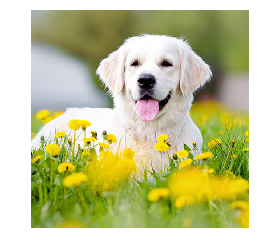

hello, human!
Your predicted breed is **drum rolls** ...
Chesapeake_bay_retriever


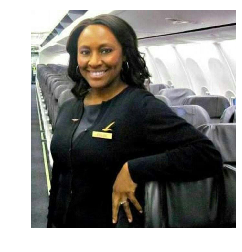

hello, human!
Your predicted breed is **drum rolls** ...
Flat-coated_retriever


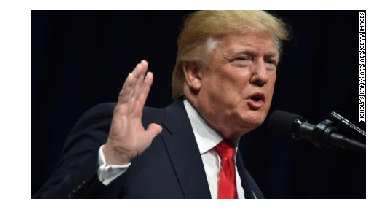

Sorry, Image doesn't contain human or dog.


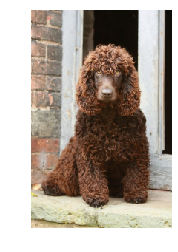

Hello, dog!
Your predicted breed is **drum rolls** ...
Belgian_sheepdog


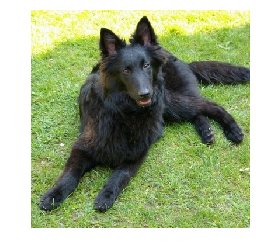

Sorry, Image doesn't contain human or dog.


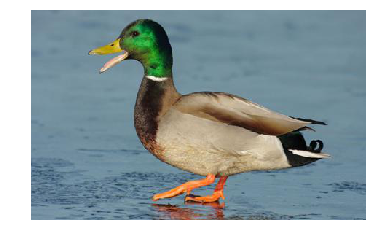

In [149]:
for i in range(len(imgs)):
  dog_breed_classifier(imgs[i])